<a href="https://colab.research.google.com/github/ahmetdemirtas1/DOCKER/blob/main/Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## İskemik inme alldata set with class 0 - 1  with 74 example which acc is 98

Import a few common modules, ensure MatplotLib plots figures inline:

In [ ]:
# Common imports
import numpy as np
import pandas as pd 

# to make this notebook's output stable across runs
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Data Acquisition

In [ ]:
# Loading the CSV file

syn = pd.read_csv('/content/sample_data/alldata2.csv')



## Quick Look at the Data Structure 

In [ ]:
syn.head()

,glcm_jointaverage,glcm_jointentropy,glcm_jointenergy,glcm_contrast,firstorder_skewness,firstorder_uniformity,firstorder_median,firstorder_energy,firstorder_maximum,firstorder_minimum,firstorder_entropy,firstorder_variance,firstorder_kurtosis,firstorder_mean,glrlm_longrunemphasis,glrlm_runlenghtnonuniformity,glrlm_shortrunemphasis,ngtdm_coarseness,ngtdm_complexity,ngtdm_strength,ngtdm_contrast,Class
0,1.738,1.566,0.428,0.246,-0.233,0.608,27,265335,36,14,0.838,17.509,2.766,27.016,20.988,20.859,0.400,0.022,0.249,0.022,0.048,0
1,1.892,0.925,0.695,0.131,-0.346,0.799,30,273138,41,12,0.509,22.022,3.549,29.806,51.111,9.876,0.323,0.050,0.131,0.049,0.013,0
2,1.640,1.820,0.341,0.252,0.316,0.528,27,369822,61,5,0.998,55.826,4.162,26.702,17.829,25.057,0.332,0.016,0.983,0.051,0.020,0
3,1.145,1.130,0.613,0.166,-0.329,0.753,19,138399,31,5,0.593,23.700,3.001,19.135,38.058,13.098,0.310,0.034,0.161,0.034,0.020,0
4,1.564,1.806,0.316,0.262,0.096,0.511,26,301674,46,8,0.983,48.045,2.521,26.259,16.925,23.988,0.353,0.018,0.260,0.018,0.063,0


In [ ]:
# To get a quick description of the data
syn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   glcm_jointaverage             74 non-null     float64
 1   glcm_jointentropy             74 non-null     float64
 2   glcm_jointenergy              74 non-null     float64
 3   glcm_contrast                 74 non-null     float64
 4   firstorder_skewness           74 non-null     float64
 5   firstorder_uniformity         74 non-null     float64
 6   firstorder_median             74 non-null     int64  
 7   firstorder_energy             74 non-null     int64  
 8   firstorder_maximum            74 non-null     int64  
 9   firstorder_minimum            74 non-null     int64  
 10  firstorder_entropy            74 non-null     float64
 11  firstorder_variance           74 non-null     float64
 12  firstorder_kurtosis           74 non-null     float64
 13  firstor

In [ ]:
glcm_jointaverage     glcm_jointentropy         glcm_jointenergy             glcm_contrast

There are 1000 instances in this dataset with 31 numerical attributes and no missing values.

In [ ]:
# Data Summary
syn.describe()

,glcm_jointaverage,glcm_jointentropy,glcm_jointenergy,glcm_contrast,firstorder_skewness,firstorder_uniformity,firstorder_median,firstorder_energy,firstorder_maximum,firstorder_minimum,firstorder_entropy,firstorder_variance,firstorder_kurtosis,firstorder_mean,glrlm_longrunemphasis,glrlm_runlenghtnonuniformity,glrlm_shortrunemphasis,ngtdm_coarseness,ngtdm_complexity,ngtdm_strength,ngtdm_contrast,Class
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,1.786257,1.399378,0.513432,0.207514,0.013162,0.662338,28.500000,326571.459459,48.391892,9.743243,0.758095,45.782865,3.166378,28.567014,41.250149,18.226635,0.343514,0.045203,0.660054,0.072986,0.028884,0.500000
std,0.310004,0.564166,0.205942,0.108565,0.234473,0.151673,3.987137,99848.666264,9.811675,7.098255,0.298729,40.899337,0.400049,3.916508,36.985978,11.484598,0.076044,0.065118,1.324099,0.079135,0.023571,0.503413
min,1.145000,0.103000,0.201000,0.011000,-0.512000,0.430000,19.000000,90978.000000,31.000000,-13.000000,0.085000,17.509000,2.521000,19.135000,6.711000,3.090000,0.134000,0.015000,0.013000,0.017000,0.000100,0.000000
25%,1.615000,0.995000,0.336500,0.128750,-0.158000,0.527250,26.000000,265571.000000,42.000000,6.000000,0.549500,24.770500,2.886250,26.132250,17.897000,9.915000,0.311250,0.021000,0.182000,0.023000,0.011000,0.000000
50%,1.784500,1.507000,0.480500,0.211000,0.003000,0.638500,29.000000,327775.500000,47.000000,11.000000,0.811500,31.304500,3.108000,28.814500,26.218000,18.128500,0.346500,0.026000,0.249000,0.043500,0.022000,0.500000
75%,1.916500,1.776000,0.669750,0.255750,0.148750,0.782500,31.000000,380102.750000,51.000000,14.750000,0.979750,42.539750,3.402750,31.223500,53.679500,22.947750,0.366750,0.045000,0.472000,0.086750,0.048000,1.000000
max,2.735000,2.780000,0.976000,0.580000,0.576000,0.978000,37.000000,591721.000000,78.000000,23.000000,1.450000,211.072000,4.719000,36.546000,167.338000,61.596000,0.570000,0.513000,9.212000,0.405000,0.088000,1.000000


In [ ]:
# Dividing the data points into features and labels
X = syn.drop('Class',axis=1) 
y = syn['Class']

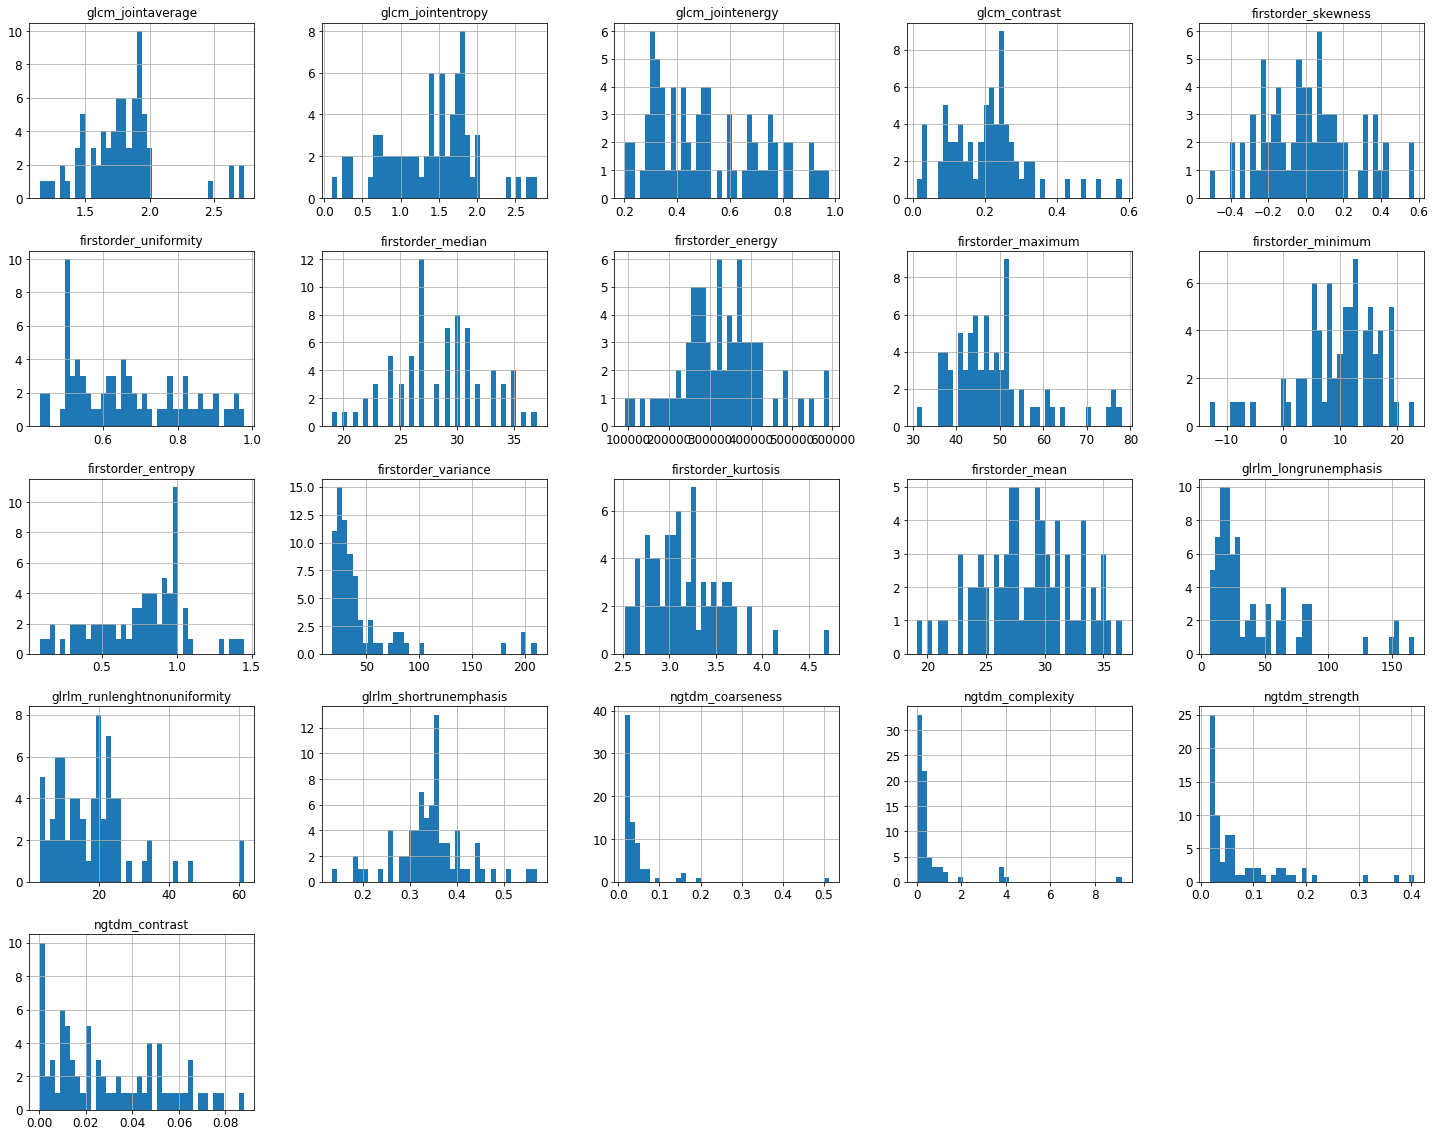

In [ ]:
# Independent Variables Visualisation
X.hist(bins=40, figsize=(25,20))
plt.show()

## Performance Metrics

The below histogram for the target attribute shows imbalanced classes. Class 0 is the dominant one with almost 85%, while Class 1 was observed 15% of the time. There are 5 scoring measurements for classification problems: Accuracy, Precision, Recall, F1-Score and ROC. Accuracy will be misleading since a not one dumb classifier can achieve 0.85. As we have synthetic data, so precision and recall will not have meaning. Therefore F1-score with PR Curve will be perefed than the ROC in order to highlight the few positive cases.

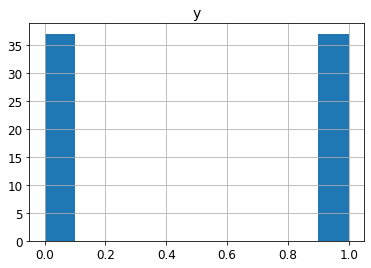

In [ ]:
# Dependent Variable visualization
y.hist()
plt.title('y',fontsize=14)
plt.show()

## Creating a validation set

In [ ]:
# Randomly stratified data split with using 80% for training while keeping 20% for validating
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, valid_index in split.split(X, y):
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    X_valid, y_valid = X.loc[valid_index], y.loc[valid_index]    
    

Confirming if the stratified sampling maintain the y class shares.

In [ ]:
y_train.value_counts()/len(y_train)

1    0.508475
0    0.491525
Name: Class, dtype: float64

In [ ]:
y_valid.value_counts()/len(y_valid)

0    0.533333
1    0.466667
Name: Class, dtype: float64

## Discover and Visualize the Data to Gain Insights

Putting the test set aside and exploring only the training set

In [ ]:
#Checking the correlation
correlation = X_train.corr()

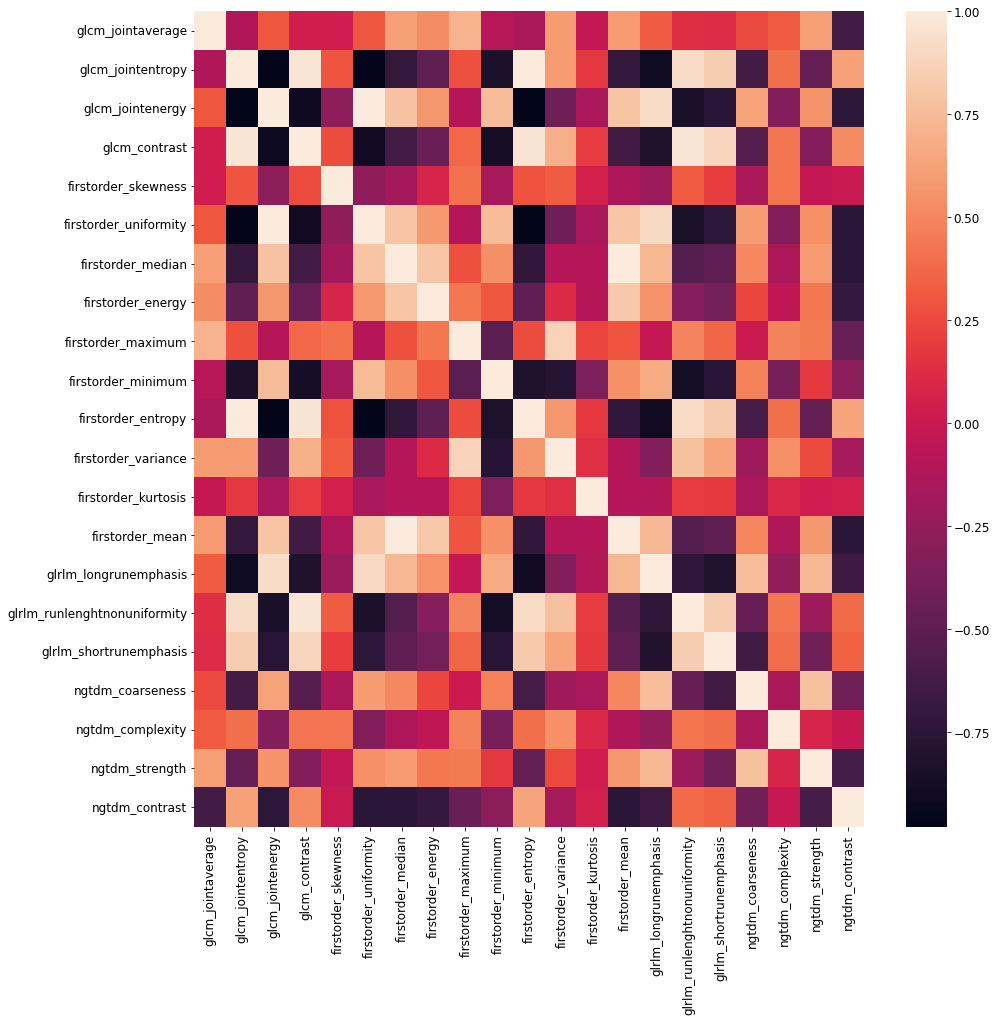

In [ ]:
# Checking the correlation between the variables
import seaborn as sns

fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlation,ax=ax)
plt.show()

The independent attributes are normally distributed but have low correlation with each other

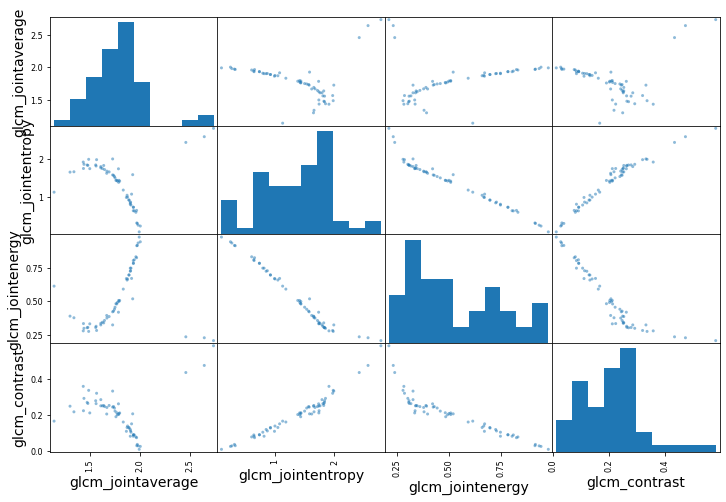

In [ ]:
# Using scatter plots to check for possible non-linear relationship for sample random varialbles
from pandas.plotting import scatter_matrix 
scatter_matrix(X_train[['glcm_jointaverage','glcm_jointentropy','glcm_jointenergy','glcm_contrast']], figsize=(12, 8))
plt.show()

Even, there are no clear non-linear realtions



# Data Preparation

Data cleaning is not required. However,standardization by fitting the scalers to training data only. It is a necessary scaling for some machine learning algorithm input. 

In [ ]:
# Standardization
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
train_sc = std_scaler.fit_transform(X_train)

In [ ]:
# Ignoring warnings 
import warnings

warnings.filterwarnings('ignore')

# Models Training, Tuning and Cross Validation 

- Starting from Ridge and trying to add polynomial features by creating a pipeline and tuning for the regularization hyperparamter alpha. The Polynomial non linear classifier is performing better than the linear Ridge. Then, taking another technique to takel the nolinear problem by using Support vector machine classifier (SVC) with gaussian kernel which didn't help.Finally, using random forest (RF) with pasting and gradient boosted regression trees which gave the the best scores.

- For Data balancing, the hyperparameter balanced classweight is used in all ridge, polynomial, SVC and RF which adjusts weights inversely proportional to class frequencies while the gradient boosing combat the class imbalance by constructing sucessive training sets.

- Training and testing all the models have done using the 10-fold cross validation.

## Ridge and Polynomial Regression

Best F1 score for train prediction with Polynomial degree = 1 is  0.7146522450296036
Best F1 score for test prediction with Polynomial degree = 1 is  0.5669047619047619
Best F1 score for train prediction with Polynomial degree = 2 is  0.9854545454545456
Best F1 score for test prediction with Polynomial degree = 2 is  0.5733333333333333


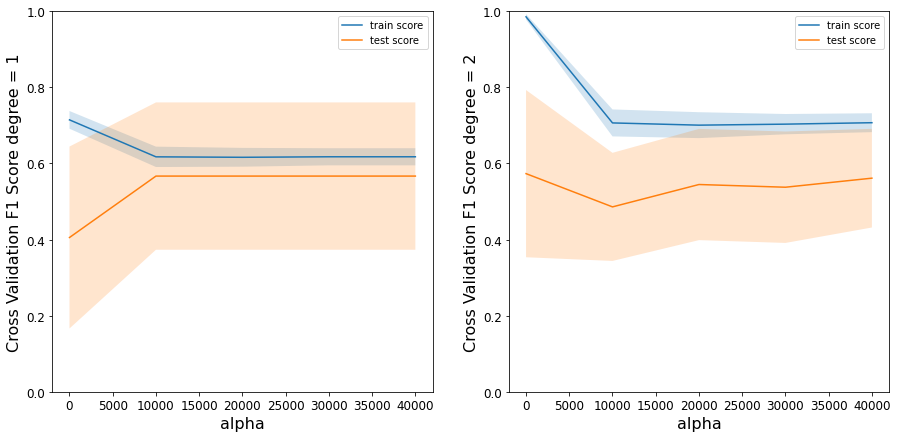

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_validate

plt.figure(figsize=(15,7))
train_mean, test_mean = [], []
train_stda, test_stda = [], []
train_stdb, test_stdb = [], []

# Training, tuning and testing the Polynomial classifiers for degree 1 (Ridge) and 2 using a pipeline   
for degree in range(1,3):
    for alpha in range(1,50000,10000):
        
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        ridge_clf = RidgeClassifier(alpha=alpha, random_state=42,class_weight='balanced') 
        
        polynomial_clf = Pipeline([
        ("poly_features", poly_features),
        ("ridge_clf", ridge_clf)
        ])
        
# Calculating F1 scores mean and standard deviation above and below the mean for every degree across the alpha values
        f1 = cross_validate(polynomial_clf, train_sc, y_train, cv=10, scoring="f1", return_train_score=True)
        train_mean.append(np.mean(f1['train_score']))
        test_mean.append(np.mean(f1['test_score']))
        train_stda.append(np.mean(f1['train_score'])-np.std(f1['train_score']))
        train_stdb.append(np.mean(f1['train_score'])+np.std(f1['train_score']))
        test_stda.append(np.mean(f1['test_score'])-np.std(f1['test_score']))
        test_stdb.append(np.mean(f1['test_score'])+np.std(f1['test_score']))
        
# Ploting the training and testing mean and standard deviation for bias and variance comparison       
    plt.subplot(120 + degree)
    plt.ylim(0,1)
    plt.plot(range(1,50000,10000),train_mean, label="train score")
    plt.fill_between(range(1,50000,10000),train_stda, train_stdb, alpha=0.2)
    plt.plot(range(1,50000,10000),test_mean, label="test score")
    plt.fill_between(range(1,50000,10000),test_stda, test_stdb, alpha=0.2)
    plt.legend(loc="auto")
    plt.xlabel("alpha", fontsize=16)
    plt.ylabel('Cross Validation F1 Score '+'degree = {}'.format(degree),fontsize=16)
    print('Best F1 score for train prediction with Polynomial degree = {} is '.format(degree) ,np.max(train_mean)) 
    print('Best F1 score for test prediction with Polynomial degree = {} is '.format(degree),np.max(test_mean))
    train_mean, test_mean = [], []
    train_stda, test_stda = [], []
    train_stdb, test_stdb = [], []

The Ridge classifier is underfitting the data while the polynomial is overfitting which over come by increasing alpha. 

In [ ]:
# Choosing alpha with a value equal to 1 for Ridge and 20000 for Polynomial which gives a good bias variance trade off
ridge_clf = RidgeClassifier(alpha=1, random_state=42,class_weight='balanced') 
poly_features = PolynomialFeatures(degree=2, include_bias=False)
ridge_clf1 = RidgeClassifier(alpha=20000, random_state=42,class_weight='balanced')
polynomial_clf = Pipeline([
                ("poly_features", poly_features),
                ("ridge_clf", ridge_clf1)
                ])
ridge_clf.fit(train_sc,y_train)
polynomial_clf.fit(train_sc,y_train)

Pipeline(steps=[('poly_features', PolynomialFeatures(include_bias=False)),
                ('ridge_clf',
                 RidgeClassifier(alpha=20000, class_weight='balanced',
                                 random_state=42))])

In [ ]:
#  Function to plot the training and testing mean and standard deviation. Also, the best 5 F1 scores summary table.  

def plot_cross_validation_curve(cv):
    df1 = pd.DataFrame({'mean_train':cv["mean_train_score"],'std_train':cv["std_train_score"]})
    df2 = pd.DataFrame({'mean_test':cv["mean_test_score"],'std_test':cv["std_test_score"]})
    df3 = pd.DataFrame(cv["params"])
    c = pd.concat([df1,df2,df3],axis=1)
    c.sort_values(by=['mean_test','mean_train'],ascending=False, inplace=True)
    c.reset_index(inplace=True)
    c = c.head(5)
    fig,ax=plt.subplots()
    ax.plot(range(5), c['mean_train'], label='train score')
    ax.fill_between(range(5), c['mean_train']-c['std_train'], c['mean_train']+c['std_train'], alpha=0.2)
    ax.plot(range(5), c['mean_test'], label='test score')
    ax.fill_between(range(5), c['mean_test']-c['std_test'], c['mean_test']+c['std_test'], alpha=0.2)
    ax.set_ylabel('Cross Validation F1 Score')
    ax.legend(loc='best')
    fig.tight_layout()
    plt.show()
    return ax,c
    

## Support Vector Machine Classifier


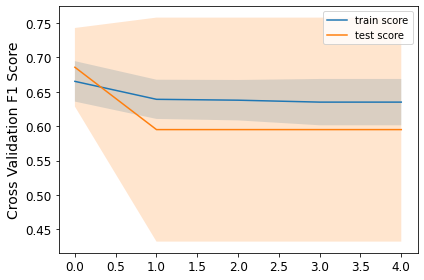

(<matplotlib.axes._subplots.AxesSubplot at 0x7f559d395710>,
    index  mean_train  std_train  mean_test  std_test          C     gamma
 0     49    0.665192   0.029423   0.685714  0.057143   3.541913  0.000164
 1     50    0.639064   0.028531   0.595000  0.162960   4.142919  0.001874
 2     84    0.637789   0.029403   0.595000  0.162960   5.077514  0.001520
 3     39    0.634986   0.033690   0.595000  0.162960  36.846573  0.000171
 4     55    0.634986   0.033690   0.595000  0.162960  29.975145  0.000210)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_svc = {"gamma": reciprocal(0.0001, 0.01), "C": uniform(1, 100)}

svc = SVC(kernel="rbf",class_weight='balanced',probability=True, random_state=42)

# Using Randomized search CV for training and tuning the SVC by searching the best gamma and c combinations 
# and cross validating as well
rnd_search_svc = RandomizedSearchCV(svc, param_distributions=param_svc,
                 n_iter=100, cv=10, scoring='f1',return_train_score=True, n_jobs=-1, random_state=42)
rnd_search_svc.fit(train_sc, y_train)

# The best SVC model
final_model_svc = rnd_search_svc.best_estimator_

# Ploting and summarizing the results for the modesl which offers the best test train scores.
cv_svc = rnd_search_svc.cv_results_
plot_cross_validation_curve(cv_svc)






The SVM classifier offers a resonable bias variance trade off.However, the mean f1 score for the best model is even less than the polynomial classifier

## Random Forest Classifier

Setting bootstrap to False work as pasting approach.Indeed, each predictor selects random subsets of the training sets by sampling without replacement and taking into consdieration the balanced weight for each sample by setting the class weight hyperparameter to balanced subsample mode.

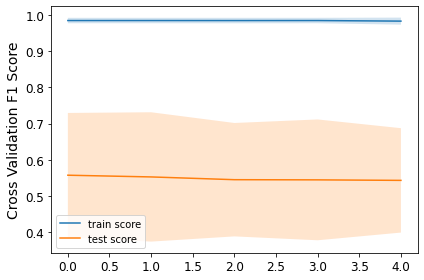

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5586d78990>,
    index  mean_train  std_train  ...  max_depth  max_features  n_estimators
 0      9    0.984974   0.007516  ...          8            16            42
 1     34    0.984974   0.007516  ...          8            16            33
 2     39    0.984906   0.007547  ...          8            17            35
 3      0    0.984974   0.007516  ...          8            17            15
 4     64    0.983358   0.009732  ...          7            15             3
 
 [5 rows x 8 columns])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint


param_forest = {
        'n_estimators': randint(low=1, high=80),
        'max_depth': randint(low=6, high=9),
        'max_features': randint(low=14,high=20)
    }

forest_clf = RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',random_state=42)

# Using Randomized search CV for training, cross validating and tuning the RF classifier with pasting approach
rnd_search_forest = RandomizedSearchCV(forest_clf, param_distributions=param_forest,
                    n_iter=100, cv=10, scoring='f1',return_train_score=True, n_jobs=-1, random_state=42)
rnd_search_forest.fit(train_sc, y_train)

# The best RF model
final_model_forest = rnd_search_forest.best_estimator_

# Ploting and summarizing the results for the modesl which offers the best test train scores.
cv_forest= rnd_search_forest.cv_results_
plot_cross_validation_curve(cv_forest)

The Random Forest classier with pasting and data balancing offer a better score while maintaining the bias variance.

## Gradient Boosting Classifier

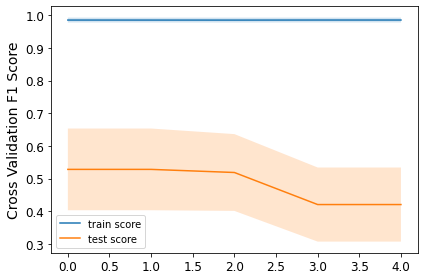

(<matplotlib.axes._subplots.AxesSubplot at 0x7f559cec5250>,
    index  mean_train  std_train  mean_test  std_test  max_depth  n_estimators
 0      7    0.985043   0.007483   0.528095  0.125021          7           110
 1      6    0.984974   0.007516   0.528095  0.125021          7           100
 2      8    0.984906   0.007547   0.518571  0.117503          7           125
 3      0    0.985111   0.007450   0.420476  0.113370          5           100
 4      2    0.985111   0.007450   0.420476  0.113370          5           125)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
param_gb = {
     
        'n_estimators': [100,110,125],
        'max_depth': [5,6,7]
    
    }

# Using Grid search CV for training, cross validating and tuning Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(learning_rate=0.6, random_state=42)
grid_search_gb = GridSearchCV(gb_clf, param_gb, cv=10, scoring='f1',return_train_score=True, n_jobs=-1)
grid_search_gb.fit(train_sc, y_train)

# The best GB model
final_model_gb = grid_search_gb.best_estimator_

# Ploting and summarizing the results for the modesl which offers the best test train scores.
cv_gb = grid_search_gb.cv_results_
plot_cross_validation_curve(cv_gb)

The Gradient Boosting classifier also shows a score that can compete the RF model. However, it's highly overfitting the training data.


## Comparing the Classifiers performance  on test sets

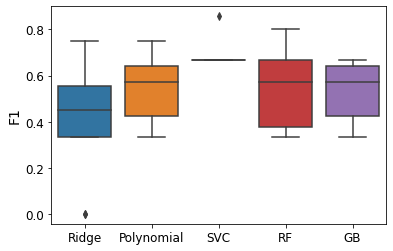

In [ ]:
from sklearn.base import clone
from sklearn.model_selection import cross_val_score

clf_names = ['Ridge','Polynomial','SVC', 'RF', 'GB']
clfs = [ridge_clf, polynomial_clf, final_model_svc, final_model_forest, final_model_gb]
all_scores = np.zeros((len(clf_names), 10))
for i in range(len(clfs)):
    clf = clone(clfs[i])
    scores = cross_val_score(clf, train_sc, y_train, cv=10, scoring='f1', n_jobs=-1)
    all_scores[i] = scores
fig, ax = plt.subplots()
sns.boxplot(data=pd.DataFrame(all_scores.T, columns=clf_names), ax=ax)
ax.set_ylabel('F1')
plt.show()

As expected the RF is the best model while comparing scores of the models on  10 Fold test sets .

## Precision recall comparison

Comparing the precision and recall for two interesting models having a decision function predictions which used as thresholds for the precision recall curve.

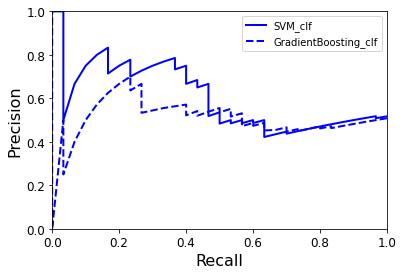

In [ ]:
# ploting the percision recall curve

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

y_scores_SVC = cross_val_predict( clone(final_model_svc), train_sc, y_train, cv = 10, method = "decision_function")
y_scores_gb = cross_val_predict( clone(final_model_gb), train_sc, y_train, cv = 10, method = "decision_function")

precisions_svc, recalls_svc,threshold_svc = precision_recall_curve(y_train, y_scores_SVC)
precisions_gb, recalls_gb,threshold_gb = precision_recall_curve(y_train, y_scores_gb)

plt.plot(recalls_svc, precisions_svc, "b-", linewidth=2,label="SVM_clf")
plt.plot(recalls_gb, precisions_gb,"b--", linewidth=2,label="GradientBoosting_clf")
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.legend(loc="upper right")
plt.show()


The Support vector machine classifier with gaussian kernel offers a higher percision above 0.85 when recall less 0.1.
The Gradient boosting precision recall curve dominates after recall above 0.15 which indicates a higher F1 score

# Evaluation on the the validation set

After tweaking the models , it's time to evaluate the final model of each classifier on the test set 

In [ ]:
# Standardizing the validion set
valid_sc = std_scaler.transform(X_valid)

In [ ]:
# predictions
y_valid_pred_ridge = ridge_clf.predict(valid_sc)
y_valid_pred_polynomial = polynomial_clf.predict(valid_sc)
y_valid_pred_svc = final_model_svc.predict(valid_sc)
y_valid_pred_forest = final_model_forest.predict(valid_sc)
y_valid_pred_gb = final_model_gb.predict(valid_sc)

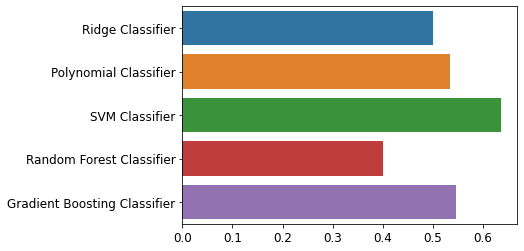

In [ ]:
# comparing f1 score on the validation data
from sklearn.metrics import f1_score

f1_ridge = f1_score(y_valid, y_valid_pred_ridge)
f1_poly = f1_score(y_valid, y_valid_pred_polynomial)
f1_svc = f1_score(y_valid, y_valid_pred_svc)
f1_forest = f1_score(y_valid, y_valid_pred_forest)
f1_gb = f1_score(y_valid, y_valid_pred_gb)
f1= {'Ridge Classifier':f1_ridge,'Polynomial Classifier':f1_poly,
     'SVM Classifier':f1_svc,'Random Forest Classifier':f1_forest,'Gradient Boosting Classifier':f1_gb}
f1_df = pd.DataFrame(f1,index=['F1'])
sns.barplot(data = f1_df, orient='h')
plt.show()

| |Model Name                    |F1 Score  |
|-|------------------------------|----------|
|1|Ridge Classifier              |0.193     |
|2|Polynomial Classifier         |0.364     |
|3|SVM Classifier                |0.349     |
|4|Random Forest Classifier      |0.492     |
|5|GradientBoosting Classifier   |0.448     |

The F1 score for the balanced Random forest exceeds all the other models with a reasonable bias variance trade off.